In [2]:
import os
import itertools
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from palettable.colorbrewer.sequential import YlGn_8
from palettable.wesanderson import Margot3_4

from ideotype.data_process import read_data, agg_sims, fetch_sim_values, parse_mature
from ideotype.analysis import identify_top_phenos, rank_all_phenos, rank_top_phenos
from ideotype.figures import plot_sims_raw, plot_sims_phenostage
from ideotype.init_params import params_sample
from ideotype.utils import read_sim, fold
from ideotype import DATA_PATH

In [3]:
run_name = 'present'

# Read in data etc.
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_{run_name}.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)

# set site as int for dataframe emrging purposes
df_all.site = df_all.site.astype(int)
df_stuck.site = df_stuck.site.astype(int)
df_wea.site = df_wea.site.astype(int)

# Queried maizsim outputs
df_sims = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_yield.csv'))
df_phys = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_phys.csv'))
df_carbon = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_carbon.csv'))
df_mass = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_mass.csv'))
df_leaves = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_leaves.csv'))
df_waterdeficit = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterdeficit.csv'))
df_waterdeficit_sum = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterdeficit_sum.csv'))
df_waterpotential = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterpotential.csv'))
df_phenology = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_pheno.csv'))
start_dates = [int(datetime.strptime(date, '%m/%d/%Y').strftime('%j')) for date in df_phenology.date_start]
df_phenology['jday'] = start_dates
df_gseason_climate = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_gseason_climate.csv'))

In [4]:
# fetch emergent properties
phenos_ranked = rank_top_phenos('present', 100, 1, 1)
df_pheno_gf = df_phenology[df_phenology.pheno == '"grainFill"']

# grain-filling length
gf_lengths = []
for pheno in phenos_ranked:
    df_sub = df_pheno_gf.query(f'cvar=={pheno}')
    gf_length = df_sub.mean()['pheno_days']
    gf_lengths.append(gf_length)
    
# grain-filling length
gf_startdates = []
for pheno in phenos_ranked:
    df_sub = df_pheno_gf.query(f'cvar=={pheno}')
    gf_startdate = df_sub.mean()['jday']
    gf_startdates.append(gf_startdate)
    
# leaf areas
LAs = fetch_sim_values(df_leaves, '"grainFill"', 'LA', phenos_ranked)

## Emergent properties to yield

Disconnect between summarized phenotype versus all raw data from singel phenotype?
- We see a general trend between grain-fill length & yield when looking at overall summarized data from all phenotypes
- However, when you look closely at one singel phenotype, there's a much larger spread in specific phenotypes, maybe suggesting a non-linear relationship?
- Also, some phenotypes have really weird patterns, looks a bit like a bell-shaped curve, or is it just more like a cloud? I think it does peak at some point, but there's just also a lot of noise that makes it hard to pin point a pattern

- acorss phenotypes and averaged across all sites, the longer grain-filling, the higher the yield.
- However, within a single phenotype and across all sites, there is usually an optimum (unless you're like pheno 5 that your stay-green is so low that you don't really reach the topping point of having too-long of a grain-filling stage).
- It seems like it's mostly the phenotypes with really long stay-green parameters that you're seeing the leveling off of grain-filling length benefits on yield (it's mostly in northern sites I think, where temps are low and grain-fill gets dragged on).
- Even with that drop though, it seems like these phenotypes still generate much higher yield than other phenotypes such that it doesn't matter that they're not reaching their optimum they still out-compete others.

Text(0, 0.5, 'yield')

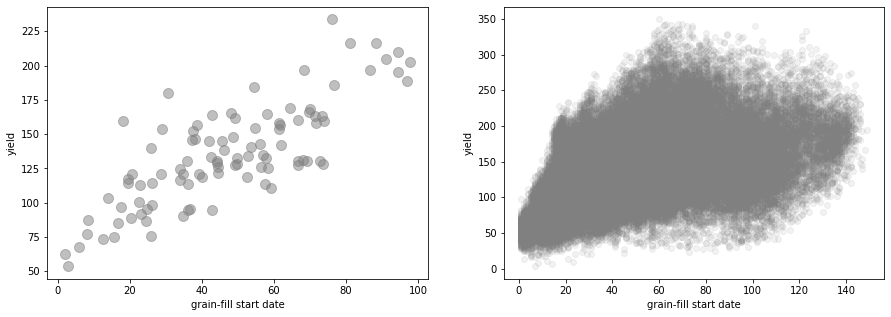

In [5]:
df_all.site = df_all.site.astype(int)
df_merged = df_pheno_gf.merge(df_all, on=['cvar','site','year'])

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df_merged.groupby('cvar').mean().pheno_days,
            df_merged.groupby('cvar').mean().dm_ear, 
            s=100, color='grey', alpha=0.5)
ax1.set_xlabel('grain-fill start date')
ax1.set_ylabel('yield')

# should try and label each with phenotype number
# maybe also add spread (error bars) across x & y?

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df_merged.pheno_days, df_merged.dm_ear, 
            alpha=0.1, color='grey')
ax2.set_xlabel('grain-fill start date')
ax2.set_ylabel('yield')
# maybe plot these in grey and mark high performers in light colors to see what region they fall in?
# make this into a heatmap or countour plot instead?

Curious that there's such a big difference in phenology within the same phenotype planted across different locations.However, I'm not sure how much this is actually due to phenotype responses to climate differences. It could also be due to the planting date differences across sites (differences could be up to ~2 months). So management + climate resposne.

Text(0, 0.5, 'grain-fill length')

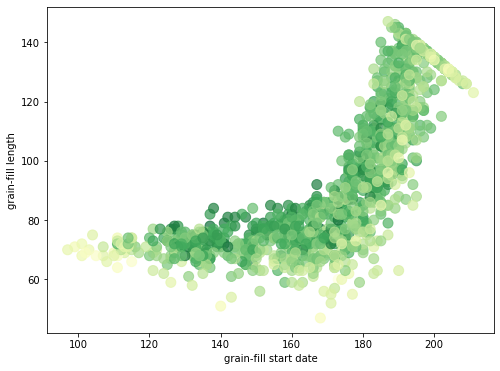

In [6]:
pheno = 65

fig = plt.figure(figsize=(8,6))
df = df_merged.query(f'cvar=={pheno}')
plt.scatter(df.jday_x, df.pheno_days, 
            c=df.dm_ear, cmap=YlGn_8.mpl_colormap, 
            s=100, alpha=0.7)

plt.xlabel('grain-fill start date')
plt.ylabel('grain-fill length')

# why do we see low yield on the end of grain-fill start?
# it's not as if they had a much shorter grain-fill length.
# that end must have high temps.
# is it because of canopy size or because of low precip?

#### Non-linear relationship between grain-fill start date & yield
- Not very obvious when looking at all phenotypes at once, but becomes more prominent when only looking at one phenotype
- This seems to be the case, but how much of it is due to impacts on grain-filling length?
- Relationship between grain-fill start & grain-fill length also seems a bit odd. Non-linear with clear inflection point? No clear relationship between the two when transition is early, but with late transition time, see a positive relationship between transition time & grain-fill length -> the later you start, the longer your grain-fill period is
- Potential reasons: later start date means you have features that promote a long vegetative stage. These traits will likely also lead to longer longevity (buffered senescence), so in general it takes much longer for the plant to die down and reach maturity?

Text(0, 0.5, 'yield')

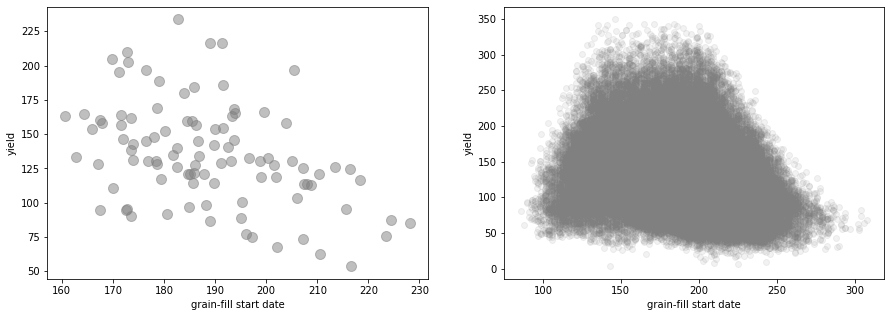

In [7]:
df_all.site = df_all.site.astype(int)
df_merged = df_pheno_gf.merge(df_all, on=['cvar','site','year'])

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df_merged.groupby('cvar').mean().jday_x,
            df_merged.groupby('cvar').mean().dm_ear, 
            s=100, color='grey', alpha=0.5)
ax1.set_xlabel('grain-fill start date')
ax1.set_ylabel('yield')

# should try and label each with phenotype number
# maybe also add spread (error bars) across x & y?

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df_merged.jday_x, df_merged.dm_ear, 
            alpha=0.1, color='grey')
ax2.set_xlabel('grain-fill start date')
ax2.set_ylabel('yield')
# maybe plot these in grey and mark high performers in light colors to see what region they fall in?
# make this into a heatmap or countour plot instead?

### Temp & phenology response between different strategies

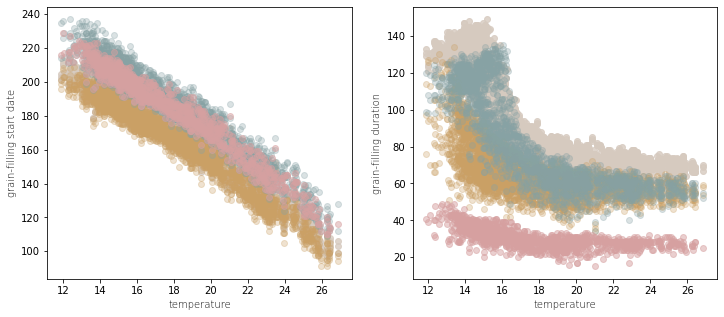

In [9]:
# phenos of interest
phenos = [4,65,46,  # slow aging
          44,58,62,  # stress averters
          88,9,  # high yielders
          5]  # compensators

# set fig parameters
colors = [Margot3_4.mpl_colors[2], Margot3_4.mpl_colors[2], Margot3_4.mpl_colors[2],
          Margot3_4.mpl_colors[1], Margot3_4.mpl_colors[1], Margot3_4.mpl_colors[1],
          Margot3_4.mpl_colors[0], Margot3_4.mpl_colors[0],
          Margot3_4.mpl_colors[3]]
alphas = [0.8, 0.8, 0.8,
          0.3, 0.3, 0.3, 
          0.3, 0.3,
          0.5]

# visualization
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel('temperature', fontweight='light')
ax1.set_ylabel('grain-filling start date', fontweight='light')
for count, pheno in enumerate(phenos):
    df_test = df_merged.query(f'cvar=={pheno}')
    ax1.scatter(df_test.temp, 
               df_test.jday_x,
               alpha = alphas[count],
               color=colors[count])
    
ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel('temperature', fontweight='light')
ax2.set_ylabel('grain-filling duration', fontweight='light')
for count, pheno in enumerate(phenos):
    df_test = df_merged.query(f'cvar=={pheno}')
    ax2.scatter(df_test.temp, 
               df_test.pheno_days,
               alpha = alphas[count],
               color=colors[count])

### temp & photosynthesis

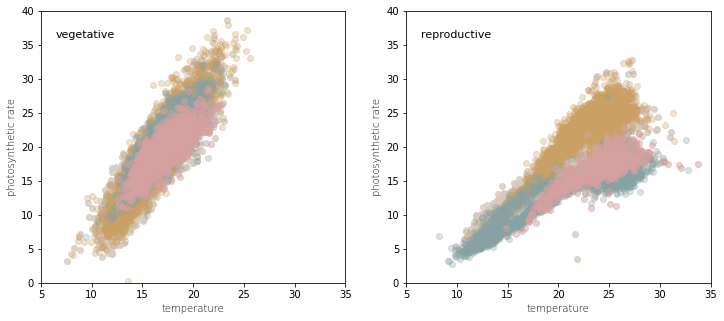

In [10]:
# set up plot parameters
colors = [Margot3_4.mpl_colors[2], Margot3_4.mpl_colors[2], Margot3_4.mpl_colors[2],
          Margot3_4.mpl_colors[1], Margot3_4.mpl_colors[1], Margot3_4.mpl_colors[1],
          Margot3_4.mpl_colors[0], Margot3_4.mpl_colors[0],
          Margot3_4.mpl_colors[3]]
alphas = [0.8, 0.8, 0.8,
          0.3, 0.3, 0.3, 
          0.3, 0.3,
          0.5]

# visualization
fig = plt.figure(figsize=(12,5))

# vegetative stage
pheno_stage = '"Emerged"'
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel('temperature', fontweight='light')
ax1.set_ylabel('photosynthetic rate', fontweight='light')
ax1.set_xlim(5,35)
ax1.set_ylim(0,40)
ax1.annotate('vegetative', xy=(0.05, 0.9), 
             xycoords='axes fraction', fontsize=11)

for count, pheno in enumerate(phenos):
    df_climate_sub = df_gseason_climate[
        df_gseason_climate.pheno == f'{pheno_stage}'].query(f'cvar=={pheno}')
    df_phys_sub = df_phys[df_phys.pheno==f'{pheno_stage}'].query(f'cvar=={pheno}')
    df_merged_gseason = df_phys_sub.merge(df_climate_sub, on=['site','year'])

    ax1.scatter(df_merged_gseason.temp_air, 
                df_merged_gseason.An,
                alpha = alphas[count],
                color=colors[count])
    
# reproductive stage
pheno_stage = '"grainFill"'
ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel('temperature', fontweight='light')
ax2.set_ylabel('photosynthetic rate', fontweight='light')
ax2.set_xlim(5,35)
ax2.set_ylim(0,40)
ax2.annotate('reproductive', xy=(0.05, 0.9), 
             xycoords='axes fraction', fontsize=11)
for count, pheno in enumerate(phenos):
    df_climate_sub = df_gseason_climate[
        df_gseason_climate.pheno == f'{pheno_stage}'].query(f'cvar=={pheno}')
    df_phys_sub = df_phys[df_phys.pheno==f'{pheno_stage}'].query(f'cvar=={pheno}')
    df_merged_gseason = df_phys_sub.merge(df_climate_sub, on=['site','year'])

    ax2.scatter(df_merged_gseason.temp_air, 
                df_merged_gseason.An,
                alpha = alphas[count],
                color=colors[count])
